In [58]:
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
data = pd.read_csv("countyall.csv")
census = pd.read_excel("census data.xlsx")
data['pop_dens'] = data["population_density_per_sq_mile"]
data = pd.merge(data, census, on="county", how="inner")
data.head()

,Unnamed: 0,date,county,state,fips,cases,deaths,Population,casesprop,deathsprop,...,pop_hislat,pop_nonwhite,med_hhi,poverty_level,voter_turnout,acs_education,crime_per_100k,rucc,rucc_descript,rural_metro
0,0,2021-07-01,Alamance,North Carolina,37001.0,19035,289.0,175029.0,0.1088,0.0017,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro
1,100,2021-07-02,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro
2,200,2021-07-03,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro
3,300,2021-07-04,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro
4,400,2021-07-05,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro


In [74]:
def categorize_hotspot(cases):
    if cases >= 50:
        return True
    else:
        return False

data['Hotspot'] = data['weeklyper100k'].apply(categorize_hotspot)

In [75]:
data.sort_values(by=['county', 'date'], inplace=True)

# Shift the 'Hotspot' column by 14 days to create a new column indicating hotspot status in two weeks
data['Hotspot_in_2_weeks'] = data.groupby('county')['Hotspot'].shift(-14)
data_grouped = data.groupby('county')['Hotspot'].sum().reset_index(name='Num_Hotspot')
print(data_grouped)

       county  Num_Hotspot
0    Alamance          136
1   Alexander          137
2   Alleghany          123
3       Anson          138
4        Ashe          130
..        ...          ...
95      Wayne          148
96     Wilkes          137
97     Wilson          140
98     Yadkin          140
99     Yancey          129

[100 rows x 2 columns]


Text(0, 0.5, 'Frequency')

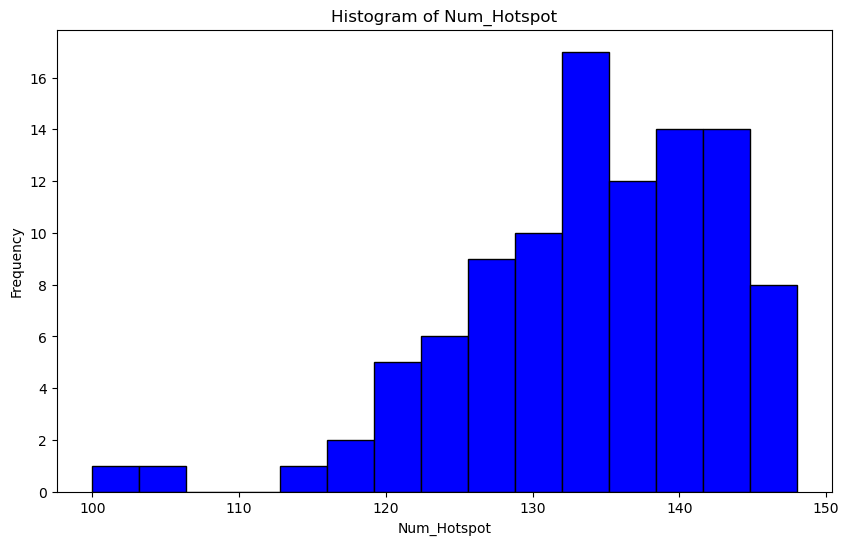

In [76]:
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(data_grouped['Num_Hotspot'], bins=15, color='blue', edgecolor='black')  # Plot histogram
plt.title('Histogram of Num_Hotspot')  # Add a title
plt.xlabel('Num_Hotspot')  # Label for the X-axis
plt.ylabel('Frequency') 

In [77]:
data_grouped.sort_values("Num_Hotspot")

,county,Num_Hotspot
45,Hertford,100
65,Northampton,106
47,Hyde,113
55,Macon,117
93,Washington,118
...,...,...
27,Dare,147
25,Cumberland,148
95,Wayne,148
46,Hoke,148


In [78]:
data_grouped_2 = data.groupby('county')['Hotspot_2'].sum().reset_index(name='Num_Hotspot')

plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(data_grouped_2['Num_Hotspot'], bins=15, color='blue', edgecolor='black')  # Plot histogram
plt.title('Histogram of Num_Hotspot')  # Add a title
plt.xlabel('Num_Hotspot')  # Label for the X-axis
plt.ylabel('Frequency') 

KeyError: 'Column not found: Hotspot_2'

In [79]:
def categorize_hotspot(cases):
    if cases >= 100:
        return True
    else:
        return False

data['Hotspot_2'] = data['weeklyper100k'].apply(categorize_hotspot)

In [80]:
# choosing categories for analysis

data_analysis = data[["county", "date", "pop_dens", "Population", "cases",'weeklyper100k', "Hotspot"]]
data_analysis = data_analysis.loc[data_analysis['county'].isin(['Lincoln','Wake'])]
data_analysis

,county,date,pop_dens,Population,cases,weeklyper100k,Hotspot
8353,Lincoln,2021-07-01,293.4,88742.0,10286,0.00,False
8354,Lincoln,2021-07-02,293.4,88742.0,10289,0.00,False
8355,Lincoln,2021-07-03,293.4,88742.0,10289,0.00,False
8356,Lincoln,2021-07-04,293.4,88742.0,10289,0.00,False
8357,Lincoln,2021-07-05,293.4,88742.0,10289,0.00,False
...,...,...,...,...,...,...,...
14222,Wake,2021-11-26,1353.3,1154170.0,135430,83.09,True
14223,Wake,2021-11-27,1353.3,1154170.0,135430,83.09,True
14224,Wake,2021-11-28,1353.3,1154170.0,135430,83.09,True
14225,Wake,2021-11-29,1353.3,1154170.0,136106,105.96,True


In [82]:
data_analysis.to_csv("analysis_data_small.csv")
data.to_csv("data_large.csv")